# 03 Modulation

Surge is a powerful synth for many reasons - the oscillators, filters, and effects - but the flexible modulation
architecture is one of the most powerful sound design tools in the instrument. We expose almost all of the modulation architecture to python as the API (the current exceptions are: We do not expose the step sequencer
and MSEG model states as of this writing).

Using the API you can query modulation routings (the mapping between a source and a parameter) and set them easily
allowing you almost complete flexibility on queriying and creating a patch.


In [1]:
import sys
# Replace this with a path to the built surgepy 
sys.path.append( "../../surge/cmake-build-debug-xc" )

import surgepy
import surgepy.constants as srco
import numpy as np
import IPython

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 8]

surgepy.getVersion()

'1.8.more-python.185c1075'

## Traversing and Understanding modulations

Lets start by investigating the modulation routings. We will choose one of the 3rd party partches in surge
and look at the mod matrix using the `getAllModRoutings` operator. We can then query individual routings and their
validity using the API.

In [2]:
s = surgepy.createSurge(44100)
p = s.getFactoryDataPath() + "patches_3rdparty/Jacky Ligon/Soundscapes/Whale Communion.fxp"
s.loadPatch(p)
mr = s.getAllModRoutings()
mr

{'global': [],
 'scene': [{'scene': [],
   'voice': [<SurgeModRouting src='Voice LFO 1' dst='A Osc 1 Feedback' depth=0.502999 normdepth=0.2515>,
    <SurgeModRouting src='Voice LFO 1' dst='A Osc 2 Low Cut' depth=-25 normdepth=-0.192308>,
    <SurgeModRouting src='Voice LFO 1' dst='A Osc 2 High Cut' depth=25 normdepth=0.192308>,
    <SurgeModRouting src='Voice LFO 1' dst='A Osc 2 Level' depth=-0.666575 normdepth=-0.666575>,
    <SurgeModRouting src='Voice LFO 1' dst='A Filter 2 Cutoff' depth=25 normdepth=0.192308>,
    <SurgeModRouting src='Voice LFO 2' dst='A Osc 1 Low Cut' depth=25 normdepth=0.192308>,
    <SurgeModRouting src='Voice LFO 2' dst='A Osc 1 High Cut' depth=-25 normdepth=-0.192308>,
    <SurgeModRouting src='Voice LFO 2' dst='A Osc 2 Feedback' depth=0.502999 normdepth=0.2515>,
    <SurgeModRouting src='Voice LFO 3' dst='A Osc 3 Feedback' depth=0.621592 normdepth=0.310796>,
    <SurgeModRouting src='Voice LFO 3' dst='A Osc 3 Low Cut' depth=-25 normdepth=-0.192308>,
    <Sur

In [3]:
vr0 = mr["scene"][0]["voice"][1]
[vr0.getSource(),
 vr0.getDest(),
 vr0.getDepth(),
 vr0.getNormalizedDepth()]

[<SurgeModSource Voice LFO 1>,
 <SurgeNamedParam 'A Osc 2 Low Cut'>,
 -25.0,
 -0.19230769574642181]

So what is that 'normalized depth' vs 'depth'? The normalize depth is scaled by the range of the
parameter to be between -1 and 1, and is what the synth uses internally. The `getModulation` API
on the surge synth uses that normalized value. So lets look - we should be able to recreate the
depth from the normalized depth and the destination min and max easily. And here we see that we can.

In [4]:
mx = s.getParamMax( vr0.getDest() );
mn = s.getParamMin( vr0.getDest() );
md = s.getModulation( vr0.getDest(), vr0.getSource() );

[
    md,
    md * ( mx - mn ),
    vr0.getDepth(),
]

[-0.19230769574642181, -25.000000447034836, -25.0]

## Creating modulations

Creating modulations requires you to locate a source, a target, and bind them with a depth. Lets do this in a 
fresh surge and do the simplest thing of binding the mixer volume for an oscillator to an LFO, which shoudl make
our waveform oscillate. To do this we use the new API where we find a mod source using the surge constants.
We can see this single routing shows up in the allModRoutings API also.

To show a bit of the expanded API, we also modify the type and rate of the LFO.

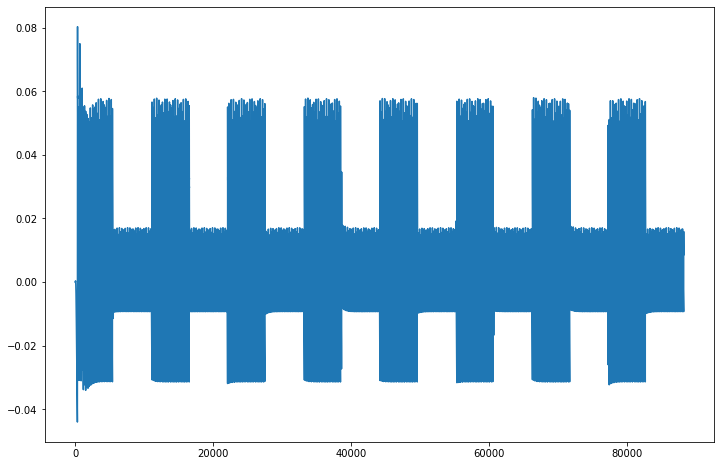

In [5]:
s = surgepy.createSurge(44100)
p = s.getPatch();

level_o1 = p["scene"][0]["level_o1"]
s.setParamVal(level_o1, 0.5)

lfoSource = s.getModSource( srco.ms_lfo1 )
lfoParms = p["scene"][0]["lfo"][0]
s.setParamVal( lfoParms["rate"], 2 ) # this is 2^val hz
s.setParamVal( lfoParms["shape"], srco.lt_square )

s.setModulation( level_o1, lfoSource, 0.1 )

onesec = int(s.getSampleRate()/s.getBlockSize())
buf = s.createMultiBlock( 2 * onesec )
s.playNote( 0, 60, 127, 0 )
s.processMultiBlock( buf )

plt.plot( buf[0] )

Not all routings are valid, as described in the manual. For instance, you can't route a voice LFO
to a scene level parameter, like an FX, or route to any integer parameter. We expose this via the
synth with a collection of checks which we briefly demonstrate here.

In [6]:
s = surgepy.createSurge(44100)
p = s.getPatch()
fx = p["fx"][0]
fxp0 = fx["p"][0]

vlfo = s.getModSource( srco.ms_lfo1 )
slfo = s.getModSource( srco.ms_slfo1 )

s.setParamVal( fx["type"], srco.fxt_delay )
# Changing FX Type requires at least one run of the audio thread
s.process()

[
    "Only Scene LFOs can modulate FX",
    vlfo,
    slfo,
    s.isValidModulation( fxp0, vlfo ),
    s.isValidModulation( fxp0, slfo )
]



['Only Scene LFOs can modulate FX',
 <SurgeModSource Voice LFO 1>,
 <SurgeModSource Scene LFO 1>,
 False,
 True]